## This notebook tests experimental features that will likely change.

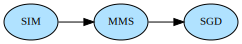

In [1]:
from lale.lib.rasl import SimpleImputer as SIM
from lale.lib.rasl import MinMaxScaler as MMS
from lale.lib.sklearn import SGDClassifier as SGD
from lale.lib.sklearn import RandomForestClassifier as RFC

def fresh_pipeline(final_est="sgd"):  #create new to guarantee fresh state after earlier fit/partial_fit, if any
    assert final_est in ["sgd", "rfc"]
    return (
        SIM(strategy="mean")
        >> MMS()
        >> (SGD(random_state=42) if final_est == "sgd" else RFC(random_state=42))
    )

fresh_pipeline().visualize()

In [2]:
from lale.lib.rasl import is_associative, is_incremental, PrioBatch, PrioStep, PrioResourceAware
from lale.lib.rasl import mockup_data_loader, fit_with_batches, cross_val_score
from sklearn.model_selection import KFold

assert is_associative(SIM)
assert is_associative(MMS)
assert is_incremental(SGD)
assert not is_incremental(RFC)

In [3]:
import lale.datasets.openml
import math
import pandas as pd
from lale.lib.lale import Project

(raw_train_X, train_y), (raw_test_X, test_y) = lale.datasets.openml.fetch("credit-g", "classification", preprocess=False)
project = Project(columns={"type": "number"}).fit(raw_train_X)
train_X, test_X = project.transform(raw_train_X), project.transform(raw_test_X)
unique_class_labels = list(train_y.unique())
print(f"unique_class_labels {unique_class_labels}")
train_data_space = train_X.memory_usage().sum() + train_y.memory_usage()
print(f"train_data_space {train_data_space}")
pd.set_option('display.max_rows', 6)
pd.concat([test_y, test_X], axis=1)

/home/hirzel/python3.7venv/lib/python3.7/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


unique_class_labels ['good', 'bad']
train_data_space 53600


,class,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
993,good,36.0,3959.0,4.0,3.0,30.0,1.0,1.0
859,good,9.0,3577.0,1.0,2.0,26.0,1.0,2.0
298,good,18.0,2515.0,3.0,4.0,43.0,1.0,1.0
...,...,...,...,...,...,...,...,...
503,bad,24.0,1216.0,4.0,4.0,38.0,2.0,2.0
263,good,12.0,2748.0,2.0,4.0,57.0,3.0,1.0
808,good,42.0,9283.0,1.0,2.0,55.0,1.0,1.0


### Example: no RASL

In [4]:
import lale.lib.rasl

accuracy_scorer = lale.lib.rasl.get_scorer("accuracy")

print(f"majority class {len(test_y[test_y == 'good']) / len(test_y):.3%}")
trained = fresh_pipeline().fit(train_X, train_y)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

majority class 70.909%
accuracy 70.909%


### Example: no batching, no cross-validation
- starting point
- behavior equivalent to sklearn
- purposely setting max_resident too low to demonstrate cache warnings

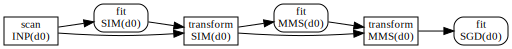

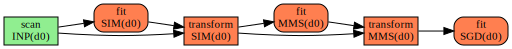

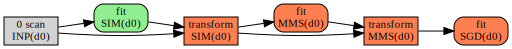

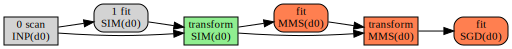

aborted spill of batch -1_d0_None
ensure_space() failed, amount_needed 53600, no_spill_space 53600, min_resident 107200, max_resident 53600


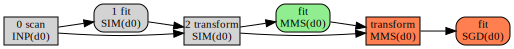

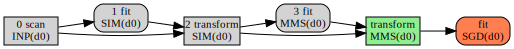

aborted spill of batch 0_d0_None
ensure_space() failed, amount_needed 53600, no_spill_space 53600, min_resident 107200, max_resident 53600


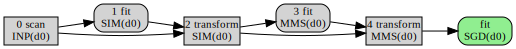

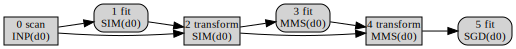

{
    "spill_count": 0,
    "load_count": 0,
    "spill_space": 0,
    "load_space": 0,
    "min_resident": 107200,
    "max_resident": 53600,
    "train_count": 3,
    "apply_count": 3,
    "metric_count": 0,
    "train_time": 0.07142210006713867,
    "apply_time": 0.09114742279052734,
    "metric_time": 0,
    "critical_count": 6,
    "critical_time": 0.16256952285766602,
}
accuracy 70.909%


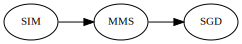

In [5]:
n_batches = 1
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
max_resident = 1 * math.ceil(train_data_space / n_batches)
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, None, unique_class_labels,
                           max_resident, PrioStep(), incremental=False, verbose=3, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")
trained.visualize()

### Example: batching using associativity where possible, non-incremental final estimator

spill /tmp/tmpgylkle3l/X_-1_d2_None.pkl /tmp/tmpgylkle3l/y_-1_d2_None.pkl
spill /tmp/tmpgylkle3l/X_-1_d1_None.pkl /tmp/tmpgylkle3l/y_-1_d1_None.pkl
load /tmp/tmpgylkle3l/X_-1_d1_None.pkl /tmp/tmpgylkle3l/y_-1_d1_None.pkl
spill /tmp/tmpgylkle3l/X_0_d0_None.pkl /tmp/tmpgylkle3l/y_0_d0_None.pkl
load /tmp/tmpgylkle3l/X_-1_d2_None.pkl /tmp/tmpgylkle3l/y_-1_d2_None.pkl
load /tmp/tmpgylkle3l/X_0_d0_None.pkl /tmp/tmpgylkle3l/y_0_d0_None.pkl
spill /tmp/tmpgylkle3l/X_0_d2_None.pkl /tmp/tmpgylkle3l/y_0_d2_None.pkl
spill /tmp/tmpgylkle3l/X_0_d1_None.pkl /tmp/tmpgylkle3l/y_0_d1_None.pkl
load /tmp/tmpgylkle3l/X_0_d1_None.pkl /tmp/tmpgylkle3l/y_0_d1_None.pkl
spill /tmp/tmpgylkle3l/X_1_d0_None.pkl /tmp/tmpgylkle3l/y_1_d0_None.pkl
load /tmp/tmpgylkle3l/X_0_d2_None.pkl /tmp/tmpgylkle3l/y_0_d2_None.pkl
load /tmp/tmpgylkle3l/X_1_d0_None.pkl /tmp/tmpgylkle3l/y_1_d0_None.pkl


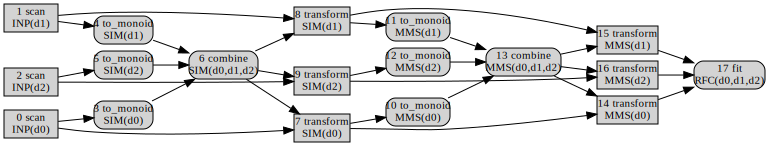

{
    "spill_count": 6,
    "load_count": 6,
    "spill_space": 107200,
    "load_space": 107200,
    "min_resident": 71520,
    "max_resident": 53601,
    "train_count": 9,
    "apply_count": 9,
    "metric_count": 0,
    "train_time": 0.8904478549957275,
    "apply_time": 0.5083796977996826,
    "metric_time": 0,
    "critical_count": 8,
    "critical_time": 1.0623304843902588,
}
accuracy 70.303%


In [6]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline("rfc"), batches, n_batches, None, unique_class_labels,
                           max_resident, PrioStep(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: pre-trained operator

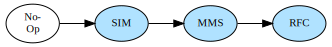

In [7]:
from lale.lib.lale import NoOp

pipeline = NoOp >> fresh_pipeline("rfc")
pipeline.visualize()

spill /tmp/tmphocdu6eu/X_-1_d2_None.pkl /tmp/tmphocdu6eu/y_-1_d2_None.pkl
spill /tmp/tmphocdu6eu/X_-1_d1_None.pkl /tmp/tmphocdu6eu/y_-1_d1_None.pkl
load /tmp/tmphocdu6eu/X_-1_d1_None.pkl /tmp/tmphocdu6eu/y_-1_d1_None.pkl
spill /tmp/tmphocdu6eu/X_0_d0_None.pkl /tmp/tmphocdu6eu/y_0_d0_None.pkl
load /tmp/tmphocdu6eu/X_-1_d2_None.pkl /tmp/tmphocdu6eu/y_-1_d2_None.pkl
load /tmp/tmphocdu6eu/X_0_d0_None.pkl /tmp/tmphocdu6eu/y_0_d0_None.pkl
spill /tmp/tmphocdu6eu/X_0_d2_None.pkl /tmp/tmphocdu6eu/y_0_d2_None.pkl
spill /tmp/tmphocdu6eu/X_0_d1_None.pkl /tmp/tmphocdu6eu/y_0_d1_None.pkl
load /tmp/tmphocdu6eu/X_0_d1_None.pkl /tmp/tmphocdu6eu/y_0_d1_None.pkl
spill /tmp/tmphocdu6eu/X_1_d0_None.pkl /tmp/tmphocdu6eu/y_1_d0_None.pkl
load /tmp/tmphocdu6eu/X_0_d2_None.pkl /tmp/tmphocdu6eu/y_0_d2_None.pkl
load /tmp/tmphocdu6eu/X_1_d0_None.pkl /tmp/tmphocdu6eu/y_1_d0_None.pkl
spill /tmp/tmphocdu6eu/X_1_d2_None.pkl /tmp/tmphocdu6eu/y_1_d2_None.pkl
spill /tmp/tmphocdu6eu/X_1_d1_None.pkl /tmp/tmphocdu6eu/y_1_d1

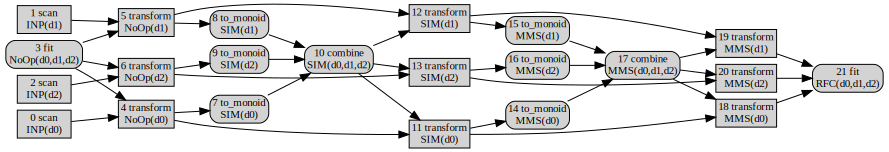

{
    "spill_count": 9,
    "load_count": 9,
    "spill_space": 160800,
    "load_space": 160800,
    "min_resident": 71520,
    "max_resident": 53601,
    "train_count": 10,
    "apply_count": 12,
    "metric_count": 0,
    "train_time": 0.7617189884185791,
    "apply_time": 0.6708540916442871,
    "metric_time": 0,
    "critical_count": 9,
    "critical_time": 1.0407767295837402,
}
accuracy 70.303%


In [8]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(pipeline, batches, n_batches, None, unique_class_labels,
                           max_resident, PrioStep(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: batching using associativity where possible, partial_fit otherwise
- unlike our batching patent, which always used partial_fit
- behavior still equivalent to sklearn
- potential advantages: less resident data; parallelism
- below are three runs with three different scheduling priorities

spill /tmp/tmp2aawy_4e/X_-1_d2_None.pkl /tmp/tmp2aawy_4e/y_-1_d2_None.pkl
spill /tmp/tmp2aawy_4e/X_-1_d1_None.pkl /tmp/tmp2aawy_4e/y_-1_d1_None.pkl
load /tmp/tmp2aawy_4e/X_-1_d1_None.pkl /tmp/tmp2aawy_4e/y_-1_d1_None.pkl
spill /tmp/tmp2aawy_4e/X_0_d0_None.pkl /tmp/tmp2aawy_4e/y_0_d0_None.pkl
load /tmp/tmp2aawy_4e/X_-1_d2_None.pkl /tmp/tmp2aawy_4e/y_-1_d2_None.pkl
load /tmp/tmp2aawy_4e/X_0_d0_None.pkl /tmp/tmp2aawy_4e/y_0_d0_None.pkl
spill /tmp/tmp2aawy_4e/X_0_d2_None.pkl /tmp/tmp2aawy_4e/y_0_d2_None.pkl
spill /tmp/tmp2aawy_4e/X_0_d1_None.pkl /tmp/tmp2aawy_4e/y_0_d1_None.pkl
load /tmp/tmp2aawy_4e/X_0_d1_None.pkl /tmp/tmp2aawy_4e/y_0_d1_None.pkl
spill /tmp/tmp2aawy_4e/X_1_d0_None.pkl /tmp/tmp2aawy_4e/y_1_d0_None.pkl
load /tmp/tmp2aawy_4e/X_0_d2_None.pkl /tmp/tmp2aawy_4e/y_0_d2_None.pkl
load /tmp/tmp2aawy_4e/X_1_d0_None.pkl /tmp/tmp2aawy_4e/y_1_d0_None.pkl


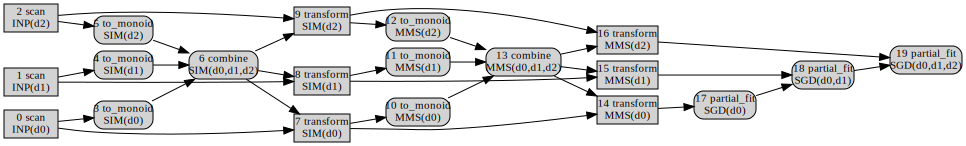

{
    "spill_count": 6,
    "load_count": 6,
    "spill_space": 107200,
    "load_space": 107200,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 11,
    "apply_count": 9,
    "metric_count": 0,
    "train_time": 0.18783354759216309,
    "apply_time": 0.39905500411987305,
    "metric_time": 0,
    "critical_count": 10,
    "critical_time": 0.28084492683410645,
}
accuracy 62.424%


In [9]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, None, unique_class_labels, max_resident,
                           PrioStep(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

spill /tmp/tmpt64acx5b/X_-1_d2_None.pkl /tmp/tmpt64acx5b/y_-1_d2_None.pkl
spill /tmp/tmpt64acx5b/X_-1_d1_None.pkl /tmp/tmpt64acx5b/y_-1_d1_None.pkl
load /tmp/tmpt64acx5b/X_-1_d1_None.pkl /tmp/tmpt64acx5b/y_-1_d1_None.pkl
spill /tmp/tmpt64acx5b/X_0_d0_None.pkl /tmp/tmpt64acx5b/y_0_d0_None.pkl
load /tmp/tmpt64acx5b/X_-1_d2_None.pkl /tmp/tmpt64acx5b/y_-1_d2_None.pkl
load /tmp/tmpt64acx5b/X_0_d0_None.pkl /tmp/tmpt64acx5b/y_0_d0_None.pkl
spill /tmp/tmpt64acx5b/X_0_d2_None.pkl /tmp/tmpt64acx5b/y_0_d2_None.pkl
spill /tmp/tmpt64acx5b/X_0_d1_None.pkl /tmp/tmpt64acx5b/y_0_d1_None.pkl
load /tmp/tmpt64acx5b/X_0_d1_None.pkl /tmp/tmpt64acx5b/y_0_d1_None.pkl
load /tmp/tmpt64acx5b/X_0_d2_None.pkl /tmp/tmpt64acx5b/y_0_d2_None.pkl


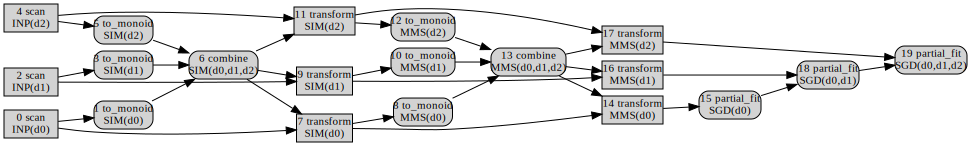

{
    "spill_count": 5,
    "load_count": 5,
    "spill_space": 89280,
    "load_space": 89280,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 11,
    "apply_count": 9,
    "metric_count": 0,
    "train_time": 0.10353636741638184,
    "apply_time": 0.31177306175231934,
    "metric_time": 0,
    "critical_count": 10,
    "critical_time": 0.19692420959472656,
}
accuracy 62.424%


In [10]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, None, unique_class_labels, max_resident,
                           PrioBatch(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

spill /tmp/tmprx7dtrq5/X_-1_d2_None.pkl /tmp/tmprx7dtrq5/y_-1_d2_None.pkl
spill /tmp/tmprx7dtrq5/X_-1_d1_None.pkl /tmp/tmprx7dtrq5/y_-1_d1_None.pkl
load /tmp/tmprx7dtrq5/X_-1_d1_None.pkl /tmp/tmprx7dtrq5/y_-1_d1_None.pkl
spill /tmp/tmprx7dtrq5/X_0_d0_None.pkl /tmp/tmprx7dtrq5/y_0_d0_None.pkl
load /tmp/tmprx7dtrq5/X_-1_d2_None.pkl /tmp/tmprx7dtrq5/y_-1_d2_None.pkl
load /tmp/tmprx7dtrq5/X_0_d0_None.pkl /tmp/tmprx7dtrq5/y_0_d0_None.pkl
spill /tmp/tmprx7dtrq5/X_1_d2_None.pkl /tmp/tmprx7dtrq5/y_1_d2_None.pkl
load /tmp/tmprx7dtrq5/X_1_d2_None.pkl /tmp/tmprx7dtrq5/y_1_d2_None.pkl


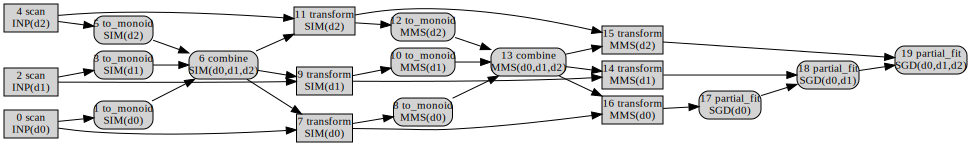

{
    "spill_count": 4,
    "load_count": 4,
    "spill_space": 71440,
    "load_space": 71440,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 11,
    "apply_count": 9,
    "metric_count": 0,
    "train_time": 0.14194488525390625,
    "apply_time": 0.17286467552185059,
    "metric_time": 0,
    "critical_count": 10,
    "critical_time": 0.16574668884277344,
}
accuracy 62.424%


In [11]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, None, unique_class_labels, max_resident,
                           PrioResourceAware(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: incremental computation, start using transformer before it has seen all data
- behavior not equivalent to sklearn, instead more similar to DL
- but may be "close enough" if operators are "convergent"
- advantage: need much less resident data
- amenable to early stopping, extracting a checkpoint

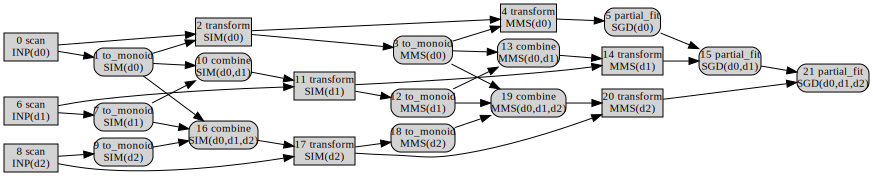

{
    "spill_count": 0,
    "load_count": 0,
    "spill_space": 0,
    "load_space": 0,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 13,
    "apply_count": 9,
    "metric_count": 0,
    "train_time": 0.10987091064453125,
    "apply_time": 0.08459234237670898,
    "metric_time": 0,
    "critical_count": 9,
    "critical_time": 0.07308745384216309,
}
accuracy 70.303%


In [12]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, None, unique_class_labels,
                           max_resident, PrioBatch(), incremental=True, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: learning curve during incremental fit_with_batches

spill /tmp/tmpbgw_db9g/X_-1_d0_None.pkl /tmp/tmpbgw_db9g/y_-1_d0_None.pkl
load /tmp/tmpbgw_db9g/X_-1_d0_None.pkl /tmp/tmpbgw_db9g/y_-1_d0_None.pkl
callback state 68.750%
spill /tmp/tmpbgw_db9g/X_-1_d2_None.pkl /tmp/tmpbgw_db9g/y_-1_d2_None.pkl
callback state 68.750%, 69.955%
load /tmp/tmpbgw_db9g/X_-1_d2_None.pkl /tmp/tmpbgw_db9g/y_-1_d2_None.pkl
callback state 68.750%, 69.955%, 71.300%


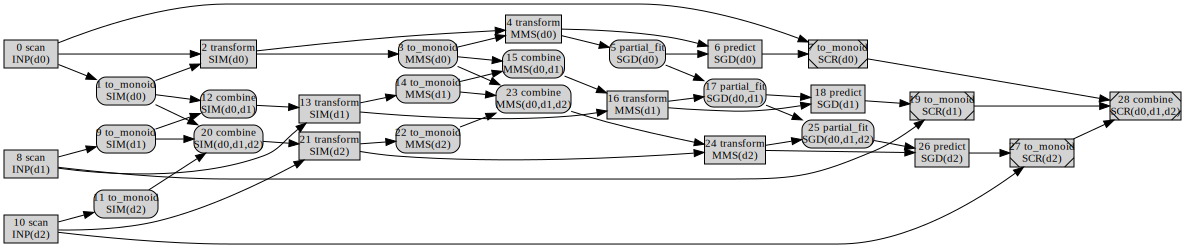

{
    "spill_count": 2,
    "load_count": 2,
    "spill_space": 35760,
    "load_space": 35760,
    "min_resident": 53760,
    "max_resident": 53601,
    "train_count": 13,
    "apply_count": 12,
    "metric_count": 4,
    "train_time": 0.1236119270324707,
    "apply_time": 0.14166522026062012,
    "metric_time": 0.04550480842590332,
    "critical_count": 12,
    "critical_time": 0.11955595016479492,
}
accuracy 70.303%


In [13]:
class DummyCallback:  # ideally, should create a dynamically updating plot in Jupyter
    def __init__(self):
        self.scores = []
    
    def __call__(self, score):
        self.scores.append(score)
        scores_s = ", ".join(f"{s:.3%}" for s in self.scores)
        print(f"callback state {scores_s}")

n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, accuracy_scorer, unique_class_labels,
                           max_resident, PrioBatch(), incremental=True, verbose=2, progress_callback=DummyCallback())
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: cross-validation without batching, using same-fold data for training
- behavior equivalent to sklearn
- reuse of lifted coefficients limited to first operator
- disambiguate some tasks by `#~f`, where f is the left-out fold
- using associativity where possible, partial_fit otherwise

spill /tmp/tmppfh_xl9x/X_-1_d0_None.pkl /tmp/tmppfh_xl9x/y_-1_d0_None.pkl
spill /tmp/tmppfh_xl9x/X_0_f0_f.pkl /tmp/tmppfh_xl9x/y_0_f0_f.pkl
spill /tmp/tmppfh_xl9x/X_-1_e0_None.pkl /tmp/tmppfh_xl9x/y_-1_e0_None.pkl
spill /tmp/tmppfh_xl9x/X_-1_f0_None.pkl /tmp/tmppfh_xl9x/y_-1_f0_None.pkl
load /tmp/tmppfh_xl9x/X_-1_d0_None.pkl /tmp/tmppfh_xl9x/y_-1_d0_None.pkl
spill /tmp/tmppfh_xl9x/X_0_f0_e.pkl /tmp/tmppfh_xl9x/y_0_f0_e.pkl
spill /tmp/tmppfh_xl9x/X_0_e0_e.pkl /tmp/tmppfh_xl9x/y_0_e0_e.pkl
spill /tmp/tmppfh_xl9x/X_0_e0_f.pkl /tmp/tmppfh_xl9x/y_0_e0_f.pkl
load /tmp/tmppfh_xl9x/X_0_e0_e.pkl /tmp/tmppfh_xl9x/y_0_e0_e.pkl
load /tmp/tmppfh_xl9x/X_0_e0_f.pkl /tmp/tmppfh_xl9x/y_0_e0_f.pkl
load /tmp/tmppfh_xl9x/X_0_f0_e.pkl /tmp/tmppfh_xl9x/y_0_f0_e.pkl
load /tmp/tmppfh_xl9x/X_-1_e0_None.pkl /tmp/tmppfh_xl9x/y_-1_e0_None.pkl
load /tmp/tmppfh_xl9x/X_0_f0_f.pkl /tmp/tmppfh_xl9x/y_0_f0_f.pkl
load /tmp/tmppfh_xl9x/X_-1_f0_None.pkl /tmp/tmppfh_xl9x/y_-1_f0_None.pkl


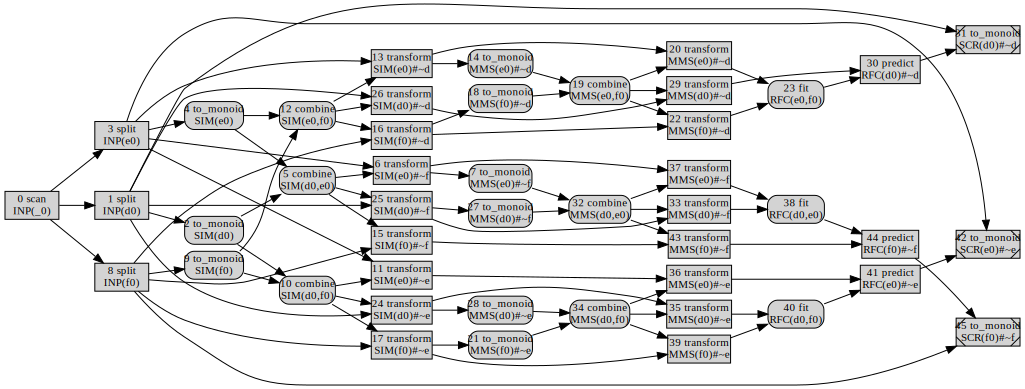

{
    "spill_count": 7,
    "load_count": 7,
    "spill_space": 124960,
    "load_space": 124960,
    "min_resident": 107200,
    "max_resident": 107200,
    "train_count": 18,
    "apply_count": 25,
    "metric_count": 3,
    "train_time": 1.2017552852630615,
    "apply_time": 0.5306072235107422,
    "metric_time": 0.05662178993225098,
    "critical_count": 11,
    "critical_time": 0.6043572425842285,
}
accuracies 72.768%, 68.161%, 69.507%


In [14]:
n_batches = 1
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline("rfc"), batches, n_batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=True, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))

### Example: cross-validation with batching, using same-fold data for training
- compared to cross-validation without batching, requires less resident memory

n_batches = 2
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline(), batches, n_batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=True, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))

### Example: cross-validation with out-of-fold samples
- not sklearn compatible
- might generalize better by following best practices for stacking ensembles
- depends on transformers being convergent
- fewer tasks overall than for cross-validation with in-fold samples

spill /tmp/tmp2sj20_6n/X_-1_d0_None.pkl /tmp/tmp2sj20_6n/y_-1_d0_None.pkl
spill /tmp/tmp2sj20_6n/X_0_f0_e.pkl /tmp/tmp2sj20_6n/y_0_f0_e.pkl
spill /tmp/tmp2sj20_6n/X_-1_f0_None.pkl /tmp/tmp2sj20_6n/y_-1_f0_None.pkl
load /tmp/tmp2sj20_6n/X_-1_d0_None.pkl /tmp/tmp2sj20_6n/y_-1_d0_None.pkl
spill /tmp/tmp2sj20_6n/X_0_f0_f.pkl /tmp/tmp2sj20_6n/y_0_f0_f.pkl
spill /tmp/tmp2sj20_6n/X_-1_e0_None.pkl /tmp/tmp2sj20_6n/y_-1_e0_None.pkl
load /tmp/tmp2sj20_6n/X_-1_e0_None.pkl /tmp/tmp2sj20_6n/y_-1_e0_None.pkl
load /tmp/tmp2sj20_6n/X_0_f0_f.pkl /tmp/tmp2sj20_6n/y_0_f0_f.pkl
load /tmp/tmp2sj20_6n/X_0_f0_e.pkl /tmp/tmp2sj20_6n/y_0_f0_e.pkl
load /tmp/tmp2sj20_6n/X_-1_f0_None.pkl /tmp/tmp2sj20_6n/y_-1_f0_None.pkl


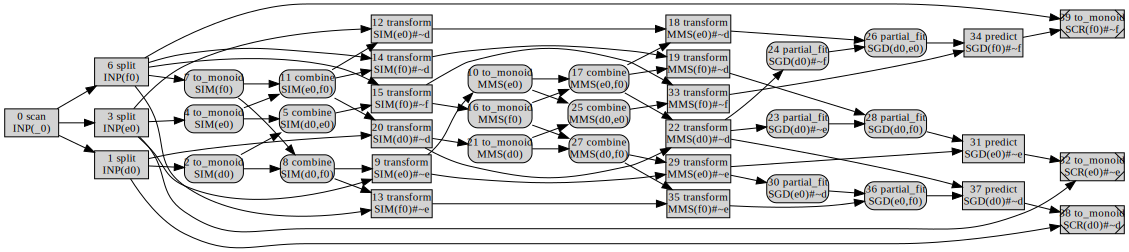

{
    "spill_count": 5,
    "load_count": 5,
    "spill_space": 89280,
    "load_space": 89280,
    "min_resident": 107200,
    "max_resident": 107200,
    "train_count": 18,
    "apply_count": 19,
    "metric_count": 3,
    "train_time": 0.10474348068237305,
    "apply_time": 0.22766971588134766,
    "metric_time": 0.04273056983947754,
    "critical_count": 12,
    "critical_time": 0.12287473678588867,
}
accuracies 69.643%, 69.507%, 70.852%


In [15]:
n_batches = 1
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline(), batches, n_batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=False, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))

spill /tmp/tmppp0_r874/X_-1__1_None.pkl /tmp/tmppp0_r874/y_-1__1_None.pkl
spill /tmp/tmppp0_r874/X_-1_d0_None.pkl /tmp/tmppp0_r874/y_-1_d0_None.pkl
spill /tmp/tmppp0_r874/X_-1_e0_None.pkl /tmp/tmppp0_r874/y_-1_e0_None.pkl
load /tmp/tmppp0_r874/X_-1__1_None.pkl /tmp/tmppp0_r874/y_-1__1_None.pkl
spill /tmp/tmppp0_r874/X_-1_f0_None.pkl /tmp/tmppp0_r874/y_-1_f0_None.pkl
spill /tmp/tmppp0_r874/X_-1_d1_None.pkl /tmp/tmppp0_r874/y_-1_d1_None.pkl
spill /tmp/tmppp0_r874/X_0_f1_e.pkl /tmp/tmppp0_r874/y_0_f1_e.pkl
spill /tmp/tmppp0_r874/X_-1_f1_None.pkl /tmp/tmppp0_r874/y_-1_f1_None.pkl
load /tmp/tmppp0_r874/X_-1_f0_None.pkl /tmp/tmppp0_r874/y_-1_f0_None.pkl
spill /tmp/tmppp0_r874/X_0_f1_d.pkl /tmp/tmppp0_r874/y_0_f1_d.pkl
spill /tmp/tmppp0_r874/X_0_f1_f.pkl /tmp/tmppp0_r874/y_0_f1_f.pkl
spill /tmp/tmppp0_r874/X_0_f0_d.pkl /tmp/tmppp0_r874/y_0_f0_d.pkl
spill /tmp/tmppp0_r874/X_-1_f0_None.pkl /tmp/tmppp0_r874/y_-1_f0_None.pkl
load /tmp/tmppp0_r874/X_-1_d0_None.pkl /tmp/tmppp0_r874/y_-1_d0_None.pkl

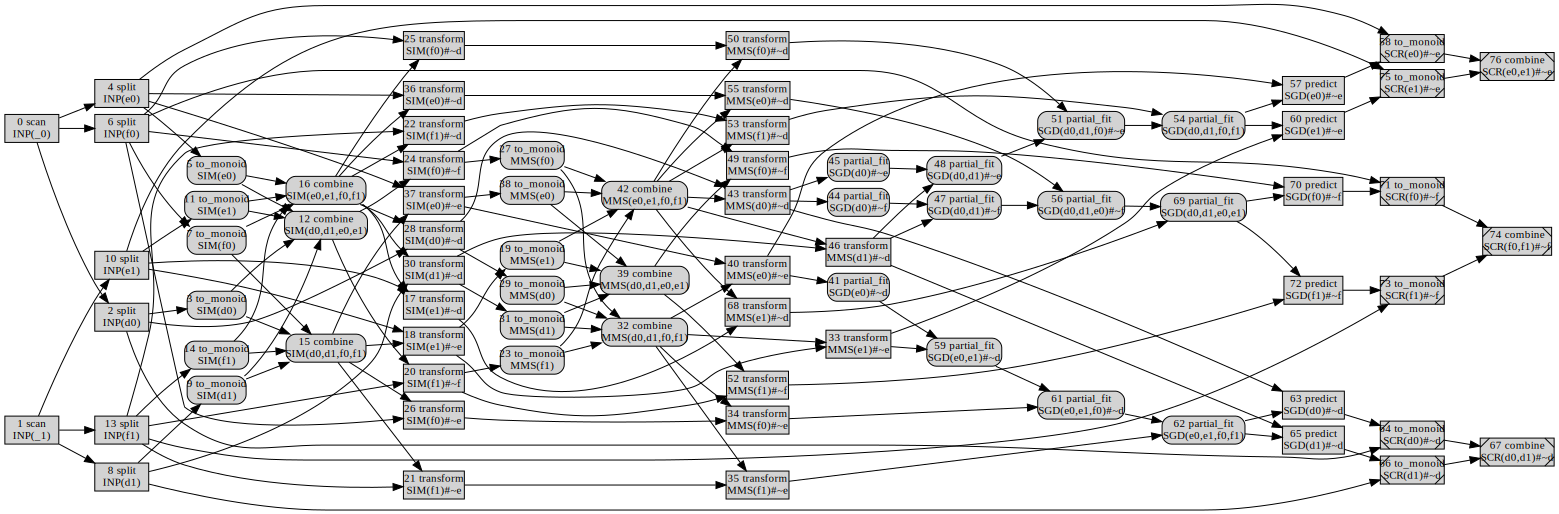

{
    "spill_count": 24,
    "load_count": 24,
    "spill_space": 231840,
    "load_space": 231840,
    "min_resident": 53600,
    "max_resident": 53600,
    "train_count": 30,
    "apply_count": 38,
    "metric_count": 9,
    "train_time": 0.2684340476989746,
    "apply_time": 0.7201380729675293,
    "metric_time": 0.06348514556884766,
    "critical_count": 15,
    "critical_time": 0.21654510498046875,
}
accuracies 68.304%, 75.000%, 66.216%


In [16]:
n_batches = 2
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline(), batches, n_batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=False, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))